In [1]:
import cv2
import face_recognition
import numpy as np
import torch
import torch.nn.functional as F
from collections import OrderedDict
from Architecture import anti_spoofing
import time
import dlib

In [ ]:
# Original Code

image1 = face_recognition.load_image_file("1.jpg")
image_encode1 = face_recognition.face_encodings(image1)[0]

image2 = face_recognition.load_image_file("3.jpg")
image_encode2 = face_recognition.face_encodings(image2)[0]

known_faces = [image_encode1, image_encode2]
known_names = ['bassem', 'Soudy']

device = torch.device("cpu")
model = anti_spoofing().to(device)
weights_path = 'model.pth'
state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    name_key = key[7:]
    new_state_dict[name_key] = value
model.load_state_dict(new_state_dict)
model.eval()

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()


    detector = dlib.get_frontal_face_detector()
    faces = detector(frame)

    for face in faces:
        x, y, width, height = face.left(), face.top(), face.width(), face.height()
        h, w, c = np.shape(frame)

        scale = min((h - 1) / height, min((w - 1) / width, 2.7))
        new_width = width * scale
        new_height = height * scale
        center_x, center_y = width / 2 + x, height / 2 + y

        left_top_x = center_x - new_width / 2
        left_top_y = center_y - new_height / 2
        right_bottom_x = center_x + new_width / 2
        right_bottom_y = center_y + new_height / 2

        left_top_x = max(0, int(left_top_x))
        left_top_y = max(0, int(left_top_y))
        right_bottom_x = min(w - 1, int(right_bottom_x))
        right_bottom_y = min(h - 1, int(right_bottom_y))

        face_region = frame[left_top_y:right_bottom_y + 1, left_top_x:right_bottom_x + 1]
        face_region = cv2.resize(face_region, (80, 80))
        face_tensor = torch.from_numpy(face_region.transpose((2, 0, 1))).float()
        face_tensor = face_tensor.unsqueeze(0).to(torch.device('cpu'))

        with torch.no_grad():
            output = model.forward(face_tensor)
            result = F.softmax(output, dim=-1).cpu().numpy()

        label = np.argmax(result)
        value = result[0][label]

        if label == 1:
            new_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            locations = face_recognition.face_locations(new_frame)
            faces = face_recognition.face_encodings(new_frame, locations)
            
            names = []
            for face in faces:
                compare = face_recognition.compare_faces(known_faces, face)
                similarity = face_recognition.face_distance(known_faces, face)
                if compare[np.argmin(similarity)]:
                    name = known_names[np.argmin(similarity)]
                else:
                    name = "Unknown"
                names.append(name)

            for (y_, h_, w_, x_), name in zip(locations, names):
                cv2.rectangle(frame, (x_, y_), (h_, w_), (255, 0, 0), 2)
                cv2.putText(frame, name, (x_ + 6, y_ - 40), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 255), 1)

        else:
            # print("Fake Face Detected. Score: {:.2f}".format(value))
            cv2.rectangle(frame, (x, y), (x + width, y + height), (255, 0, 0), 2)
            cv2.putText(frame, 'Fake', (x + 6, y - 40), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 255), 1)

        cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [9]:
# Video Cam Code

import matplotlib.pyplot as plt
import cv2
import face_recognition
import numpy as np
import torch
import torch.nn.functional as F
from collections import OrderedDict
from Architecture import anti_spoofing
import time

def load_model():
    global model
    device = torch.device("cpu")
    model = anti_spoofing().to(device)
    weights_path = 'model.pth'
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        name_key = key[7:]
        new_state_dict[name_key] = value
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

def crop_image(org_img, x, y, width, height, s=2.7, space=4):
    h, w, c = np.shape(org_img)
    scale = min((h - 1) / height, min((w - 1) / width, s))
    new_width = width * scale
    new_height = height * scale
    center_x, center_y = width / 2 + x, height / 2 + y

    left_top_x = max(center_x - new_width / 2 - space, 0)
    left_top_y = max(center_y - new_height / 2 - space, 0)
    right_bottom_x = min(center_x + new_width / 2 + space, w - 1)
    right_bottom_y = min(center_y + new_height / 2 + space, h - 1)

    image = org_img[int(left_top_y):int(right_bottom_y) + 1,
                    int(left_top_x):int(right_bottom_x) + 1]

    image = cv2.resize(image, (80, 80))

    return image


def preprocess(img):
    
    face_tensor = torch.from_numpy(img.transpose((2, 0, 1))).float()
    face_tensor = face_tensor.unsqueeze(0).to(torch.device('cpu'))
    
    return face_tensor

def predict(face_tensor):

    with torch.no_grad():
            output = model.forward(face_tensor)
            result = F.softmax(output, dim=-1).cpu().numpy()
    label = np.argmax(result)
    value = result[0][label]

    return label, value
    
image1 = face_recognition.load_image_file("2.jpg")
image_encode1 = face_recognition.face_encodings(image1)[0]

image2 = face_recognition.load_image_file("3.jpg")
image_encode2 = face_recognition.face_encodings(image2)[0]

known_faces = [image_encode1, image_encode2]
known_names = ['bassem', 'Soudy']

model = load_model()

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    locations = face_recognition.face_locations(rgb_frame)
    faces = face_recognition.face_encodings(rgb_frame, locations)
    
    for face, location in zip(faces, locations):
        y_min, x_max, y_max, x_min = location
        croped_image = crop_image(rgb_frame, s = 3.4, x = x_min, y = y_min, width = (x_max - x_min), height = (y_max - y_min))
        
        face_tensor = preprocess(croped_image)
        label, value = predict(face_tensor)
        
        if label == 1 and value > 0.5:            
        
            face_distances = face_recognition.face_distance(known_faces, face)
            best_match_index = np.argmin(face_distances)
            print(value)
            
            recognition_threshold = 0.6
            if face_distances[best_match_index] < recognition_threshold:
                name = known_names[best_match_index]
            else:
                name = "Unknown"

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(frame, name, (x_min + 6, y_min - 40), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 255), 1)

        else:
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
            cv2.putText(frame, 'Fake', (x_min + 6, y_min - 40), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 255), 1)

        cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


torch.Size([1, 512])
0.99948835
torch.Size([1, 512])
0.99925894
torch.Size([1, 512])
0.9994222
torch.Size([1, 512])
0.99940753
torch.Size([1, 512])
0.9988481
torch.Size([1, 512])
0.9994368
torch.Size([1, 512])
0.99961925
torch.Size([1, 512])
0.9992933
torch.Size([1, 512])
0.9994266
torch.Size([1, 512])
0.997494
torch.Size([1, 512])
0.9956435
torch.Size([1, 512])
0.9978223
torch.Size([1, 512])
0.99596334
torch.Size([1, 512])
0.9974999
torch.Size([1, 512])
0.9974759
torch.Size([1, 512])
0.99798393
torch.Size([1, 512])
0.9916026
torch.Size([1, 512])
0.9940773
torch.Size([1, 512])
0.991574
torch.Size([1, 512])
0.9817852
torch.Size([1, 512])
0.9955173
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512])


torch.Size([1, 512])
1 0.502706
torch.Size([1, 512])
1 0.99735117
torch.Size([1, 512])
1 0.99988735
4.955268621444702


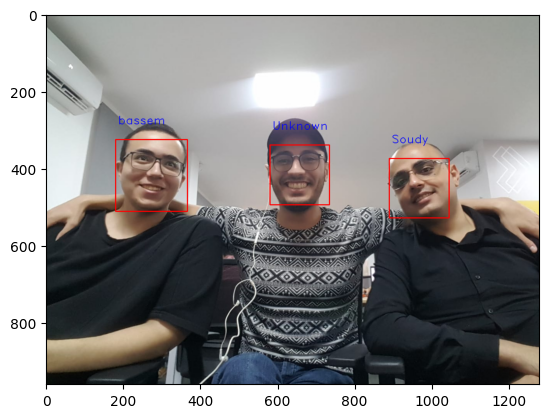

In [2]:
# Image Code
import matplotlib.pyplot as plt
import cv2
import face_recognition
import torch
import torch.nn.functional as F
from collections import OrderedDict
from Architecture import anti_spoofing
import time
import numpy as np


def load_model():
    global model
    device = torch.device("cpu")
    model = anti_spoofing().to(device)
    weights_path = 'model.pth'
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        name_key = key[7:]
        new_state_dict[name_key] = value
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

def crop_image(org_img, x, y, width, height, s=2.7, space=5):
    h, w, c = np.shape(org_img)
    scale = min((h - 1) / height, min((w - 1) / width, s))
    new_width = width * scale
    new_height = height * scale
    center_x, center_y = width / 2 + x, height / 2 + y

    left_top_x = max(center_x - new_width / 2 - space, 0)
    left_top_y = max(center_y - new_height / 2 - space, 0)
    right_bottom_x = min(center_x + new_width / 2 + space, w - 1)
    right_bottom_y = min(center_y + new_height / 2 + space, h - 1)

    image = org_img[int(left_top_y):int(right_bottom_y) + 1,
                    int(left_top_x):int(right_bottom_x) + 1]

    image = cv2.resize(image, (80, 80))

    return image

def preprocess(img):
    
    face_tensor = torch.from_numpy(img.transpose((2, 0, 1))).float()
    face_tensor = face_tensor.unsqueeze(0).to(torch.device('cpu'))
    
    return face_tensor

def predict(face_tensor):

    with torch.no_grad():
            output = model.forward(face_tensor)
            result = F.softmax(output, dim=-1).cpu().numpy()
    label = np.argmax(result)
    value = result[0][label]

    return label, value
start = time.time()
image1 = face_recognition.load_image_file("2.jpg")
image_encode1 = face_recognition.face_encodings(image1)[0]

image2 = face_recognition.load_image_file("3.jpg")
image_encode2 = face_recognition.face_encodings(image2)[0]

known_faces = [image_encode1, image_encode2]
known_names = ['bassem', 'Soudy']

model = load_model()


img = cv2.imread(r"C:\Users\user\OneDrive - Delta Academy for Science\Desktop\b795847e-dcc9-439a-bec8-af1fcabe01cd.jpg")
# img = cv2.imread(r"C:\Users\user\OneDrive - Delta Academy for Science\Desktop\ed026152-17f6-4fb9-a8e1-ad50ff0a3d8c.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
locations = face_recognition.face_locations(img)
faces = face_recognition.face_encodings(img, locations)

for face, location in zip(faces, locations):

    y_min, x_max, y_max, x_min = location
    croped_image = crop_image(img, s = 3.2, x = x_min, y = y_min, width = (x_max - x_min), height = (y_max - y_min))
    face_tensor = preprocess(croped_image)
    label, value = predict(face_tensor)
    cv2.imwrite("test.jpg", croped_image)
    
    if label == 1 and value > 0.5:            
        print(label, value)
        
        face_distances = face_recognition.face_distance(known_faces, face)
        best_match_index = np.argmin(face_distances)

        recognition_threshold = 0.5

        if face_distances[best_match_index] < recognition_threshold:
            name = known_names[best_match_index]
        else:
            name = "Unknown"
        
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, name, (x_min + 6, y_min - 40), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 255), 1)

    else:
        
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(img, 'Fake', (x_min + 6, y_min - 40), cv2.FONT_HERSHEY_DUPLEX, 1.0, (0, 0, 255), 1)
end = time.time()
print(end - start)
plt.imshow(img)


In [6]:
# Window Code
import cv2
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk
import cv2
import numpy as np
import face_recognition
import torch
import torch.nn.functional as F
from collections import OrderedDict
from Architecture import anti_spoofing
import time

def load_model():
    global model
    device = torch.device("cpu")
    model = anti_spoofing().to(device)
    weights_path = 'model.pth'
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        name_key = key[7:]
        new_state_dict[name_key] = value
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

def crop_image(org_img, x, y, width, height, s=2.7, space=0):
    h, w, c = np.shape(org_img)
    scale = min((h - 1) / height, min((w - 1) / width, s))
    new_width = width * scale
    new_height = height * scale
    center_x, center_y = width / 2 + x, height / 2 + y

    left_top_x = max(center_x - new_width / 2 - space, 0)
    left_top_y = max(center_y - new_height / 2 - space, 0)
    right_bottom_x = min(center_x + new_width / 2 + space, w - 1)
    right_bottom_y = min(center_y + new_height / 2 + space, h - 1)

    image = org_img[int(left_top_y):int(right_bottom_y) + 1,
                    int(left_top_x):int(right_bottom_x) + 1]

    image = cv2.resize(image, (80, 80))

    return image


def preprocess(img):
    face_tensor = torch.from_numpy(img.transpose((2, 0, 1))).float()
    face_tensor = face_tensor.unsqueeze(0).to(torch.device('cpu'))
    return face_tensor

def predict(face_tensor):
    with torch.no_grad():
        output = model.forward(face_tensor)
        result = F.softmax(output, dim=-1).cpu().numpy()
    label = np.argmax(result)
    value = result[0][label]
    return label, value

image1 = face_recognition.load_image_file("2.jpg")
image_encode1 = face_recognition.face_encodings(image1)[0]

image2 = face_recognition.load_image_file("3.jpg")
image_encode2 = face_recognition.face_encodings(image2)[0]

known_faces = [image_encode1, image_encode2]
known_names = ['bassem', 'Soudy']  

class CameraApp:
    def __init__(self, window, window_title):
        self.window = window
        self.window.title(window_title)

        self.video_source = 0  
        self.vid = cv2.VideoCapture(self.video_source)

        self.canvas = tk.Canvas(window, width=self.vid.get(3), height=self.vid.get(4))
        self.canvas.pack()

        self.btn_capture = tk.Button(window, text="Capture", width=10, command=self.capture_image)
        self.btn_capture.pack(padx=10, pady=10)

        self.update()

    def capture_image(self):
        start_time = time.time()
        ret, frame = self.vid.read()
        if ret:
            locations = face_recognition.face_locations(frame)
            faces = face_recognition.face_encodings(frame, locations)
            result_text = ""  

            for face, location in zip(faces, locations):
                y_min, x_max, y_max, x_min = location
                croped_image = crop_image(frame, s=2.7, x=x_min, y=y_min, width=(x_max - x_min), height=(y_max - y_min))
                face_tensor = preprocess(croped_image)
                label, value = predict(face_tensor)

                if label == 1 and value > 0.65:
                    face_distances = face_recognition.face_distance(known_faces, face)
                    best_match_index = np.argmin(face_distances)
                    recognition_threshold = 0.6
                    if face_distances[best_match_index] < recognition_threshold:
                        name = known_names[best_match_index]
                    else:
                        name = "Unknown"
                    result_text += f"Recognized: {name}\n"  
                else:
                    result_text += "Fake\n"  
            elapsed_time = time.time() - start_time  
            print(f"Time taken for processing: {elapsed_time:.2f} seconds")
        result_label.config(text=result_text)

            
    def update(self):
        ret, frame = self.vid.read()
        if ret:
            self.photo = ImageTk.PhotoImage(image=Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
            self.canvas.create_image(0, 0, image=self.photo, anchor=tk.NW)
        self.window.after(10, self.update)

    def __del__(self):
        if self.vid.isOpened():
            self.vid.release()

root = tk.Tk()
app = CameraApp(root, "Camera App")
result_label = tk.Label(root, text="", font=("Arial", 14))
result_label.pack(padx=20, pady=20)
model = load_model()
time.time
root.mainloop()


torch.Size([1, 512])
Time taken for processing: 0.41 seconds
